# Airbnb in Amsterdam (The Netherlands) 

by Jos den Ronden

[0. Import packages and define functions](#init) <br />
[1. Framing the business questions](#businessquestions) <br />
[2. Data understanding](#dataunderstanding)<br />
[2.1 Import and explore listing details](#listingdetails)<br />
[2.1.1 Import the data](#importdf1)<br />
[2.1.2 Drop columns with too many missings](#dropnacolumns)<br />
[2.1.3 Explore categorical columns](#explorecategorical)<br />
[2.1.4 Findings exploring categorical columns](#findingsexplorecategorical)<br />
[2.1.5 Wrangling categorical columns](#datawranglingcategorical)<br />
[2.1.6 Explore numeric columns](#explorenumeric)<br />
[2.1.7 Findings exploring numeric columns](#findingsexplorenumeric)<br />
[2.1.8 Wrangling numeric columns](#wranglingnumericcolumns)<br />
[2.1.9 Note on the unit of analysis](#unitofanalysis)<br />
[2.2 Explore listing summaries](#listingsummaries)<br />
[2.2.1 Import, explore, and wrangle the data](#importdatadf2)<br />
[2.2.2 Findings exploring listings data set](#findings_listings)<br />
[2.3 Merge the datasets](#mergedf1df2)<br />
[2.3.1 Check on equality of some columns, and drop if they are equal](#checkequality)<br />
[2.3.2 Check on missing values](#checkmissings)<br />
[2.3.3  Findings merging data sets](#findings_merge)<br />
[3. Pre-modeling](#premodeling)<br />
[3.1 Number of regular- and superhosts](#regular_and_superhosts)<br />
[3.2 The 10 neighbourhoods with the most listings](#neighbourhood)<br />
[3.3 The distribution of price](#price)<br />
[3.4 Price by neighbourhood](#price_neighbourhood)<br />
[4 Modeling - Answering the business questions](#answeringbusinessquestions)<br />
[4.1 Are superhosts really super?](#businessquestion1)<br />
[4.1.1 Difference with respect to price](#businessquestion1_price)<br />
[4.1.2 Difference between with respect to overall rating](#businessquestion1_overall_rating)<br />
[4.1.3 Difference between with respect to aspect ratings](#businessquestion1_ratings)<br />
[4.1.4 Difference between with respect to instant bookable](#businessquestion1_instant_bookable)<br />
[4.1.5 Conclusion](#conclusion_question_1)<br />
[4.2 What are the drivers of customer satisfaction?](#businessquestion2)<br />
[4.2.1  Correlations between the rating columns](#correlations)<br />
[4.2.2  Identify the drivers of overall rating (unstandardized solution)](#unstandardized)<br />
[4.2.3  Identify the drivers of overall rating (standardized solution)](#standardized)<br />
[4.2.4 Conclusion](#conclusion_question_2)<br />
[4.3 What is a fair price to ask for a typical object in Amsterdam?](#businessquestion3)<br />
[4.3.1 Derive distance to the city center](#derive_distance)<br />
[4.3.2 Select records with no missings for the rating columns](#nomissingsforratings)<br />
[4.3.3 Select "typical" listings by business rules](#whatistypical1)<br />
[4.3.4 Select "typical" listings by data driven methods](#whatistypical2)<br />
[4.3.5 Modeling: Predict price ](#predict_price)<br />
[4.3.6 Evaluate the models](#evaluation_models)<br />
[4.3.7 Deploy the model](#deploy)<br />

<a id='init'></a>
## 0. Import packages and define functions

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

import statsmodels.api as sm
from scipy.stats.mstats import zscore
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#CREATE DUMMIES WITH PANDAS PD.

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df       - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_dummy_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df


In [3]:
#CLEAN DATA AND FIT MODELS.
def clean_fit_models(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=481, algorithm='regression'):
    '''
    INPUT:
    df           - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols     - list of strings that are associated with names of the categorical columns
    dummy_na     - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size    - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state   - an int that is provided as the random state for splitting the data into training and test 
    algorithm    - the algorithm type {regression|randomforest}
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    This function:
    1. Drops the rows with missing response values
    2. Drops columns with NaN for all the values
    3. Uses create_dummy_df to dummy categorical columns
    4. Fills the median of the column for any missing values
       (median rather than the mean,  because it is less sensitve to outliers than the mean)
    5. Splits the data into an X matrix (predictors) and a response vector y (label)
    6. Creates training and test sets of data
    7. Instantiates a LinearRegression model with normalized data
    8. Fits the model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''
    # Drop the rows with missing response values
    df  = df.dropna(subset=[response_col], axis=0)

    # Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    # Create dummies for the categorical columns
    df = create_dummy_df(df, cat_cols, dummy_na)

    # Replace missing values by the median of the respective column
    fill_median = lambda col: col.fillna(col.median())
    df = df.apply(fill_median, axis=0)


    # Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    if algorithm == 'regression':
        model = LinearRegression(normalize=True) # Instantiate
        model.fit(X_train, y_train) #Fit

        #Predict test set using the regression model
        y_test_preds = model.predict(X_test)
        y_train_preds = model.predict(X_train)
    else:  #random_forest
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        model = RandomForestRegressor(n_estimators=20, random_state=0) #instantiate
        
        #Predict test set using the random forest model
        model.fit(X_train, y_train)
        X_test = sc.transform(X_test)
        y_test_preds = model.predict(X_test)
        

    # Metrics on the test data
    test_score_r2   = r2_score(y_test, y_test_preds)
    test_score_mae  = mean_absolute_error(y_test, y_test_preds)
    test_score_mse  = mean_squared_error(y_test, y_test_preds)
    test_score_rmse = np.sqrt(test_score_mse)

    return test_score_r2, test_score_mae, test_score_mse, test_score_rmse, model


In [4]:
#Pie chart, with percentages, might need that a few times. I used:
#https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct

def make_autopct(values):
    '''
    Takes in counts and returns percentages
    '''
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def my_piechart (df, nomvar):
    '''
    Takes in dataframe and dataframe column, and a pie chart with percentages
    '''
    cat_labels = df[nomvar].value_counts().index
    cat_counts = df[nomvar].value_counts()
    plt.pie(cat_counts, labels=cat_labels, autopct=make_autopct(cat_counts), startangle = 90,counterclock = False)
    plt.title (nomvar)
    plt.axis('square');


<a id='businessquestions'></a>
## 1. Framing the business questions

In this notebook, I will address three business questions, related to Airbnb:

* Is there a difference between "superhosts" and "regular" hosts with respect to ratings of cleanliness, checking in, among other things? In short, are superhosts really super?

* What are the drivers of satisfaction of AirBnB customers?

* What would be a fair price of a typical Airbnb property in Amsterdam?

<a id='dataunderstanding'></a>
### 2. Data understanding (and the first data preparation)

To answer the three questions, I will use Airbnb data collected for Amsterdam (The Netherlands), last scraped at June 11, 2000, and available at the [InsideAirbnb website](http://insideairbnb.com/get-the-data.html).

I will import two data files:

* detail listings: detail info about the listings
* summary information about the listings

I will expore each of the data files, select rows and columns depending on the quality of the data and their relevance to answer the business questions. 

I will also do some first data preparation, such as fixing the type of columns (in particular for the details dataset).

Then, I will merge the two data sets, which will form the data set for further analyses. 

<a id='listingdetails'></a>
### 2.1 Import and explore listing details

<a id='importdf1'></a>
### 2.1.1 Import the data

In [5]:
df1 = pd.read_csv('AMSTERDAM_details_listings.csv', low_memory=False)
print(df1.shape)
#print(df1.tail())

(19352, 106)


<a id='dropnacolumns'></a>
### 2.1.2 Drop columns with too many missings

I will drop columns with more than 50% missing values.    

In [6]:
most_missing_cols = set(df1.columns[df1.isnull().mean() > 0.50])
df1.drop(most_missing_cols, axis=1, inplace=True)
print(df1.shape)

(19352, 95)


<a id='explorecategorical'></a>
### 2.1.3 Explore categorical columns

In [7]:
cat_cols = df1.select_dtypes(include=['object']).copy().columns
#I commented out the next commands, to not produce the output... 
#print(df1.info())
#for col in cat_cols:
#    print(df1[col].value_counts())

<a id='findingsexplorecategorical'></a>
### 2.1.4 Findings exploring categorical columns

By walking through the output of the info and value counts:

* Some columns are irrelevant to answer the business questions (the columns pertaining to host name, their neighborhod, URL columns, and such)

* Some columns store text (e.g., **house_rules**; they  also might be in various languages). Text analysis needs special tools, beyond the scope of this project (I think)

* Some columns  are or are almost a constant (about 1% in one category, 99% in another; e.g., **requires_license**). Therefore, they will add nothing to the prediction of any other field, and I can ignore them.

* For some columns, there is a better version available (e.g., **neighborhood** in favor of **neighborhood_cleansed**).

* Some columns take, in the context of this assignment, too much dataprep to fix (e.g., **calendar_updated**)

* Some columns are typed as object, because they are prefixed with a dollar or percent sign (e.g., **price**). However, these are actually quantitative columns.

* The **host_since** column is typed as object, but it should be typed as date.

* The **property_type** column has many categories, with a lot of categories having a frequency of less than 5. Needs to be condensed another column with fewer categories.

* The **room_type** column has one large category (entire home/apartment, and the remaining categories have fewer counts. I will make this a binary column: entire home/apartment vs other.

* The **host_is_superhost** column has values f and t. It is better to have more meaningful values, like No and Yes.

<a id='datawranglingcategorical'></a>
### 2.1.5 Wrangling categorical columns

I will:

* Drop columns
* Change the type of categorical field that actually are quantitative
* Recode columns

In [8]:
#Drop columns.
cat_cols_to_drop = ['listing_url','last_scraped', 'space', 'name', 'summary', 'description',
                'scrape_id', 'neighborhood_overview', 'host_neighbourhood',
                'transit', 'access', 'interaction', 'house_rules', 'host_about',
                'experiences_offered', 'picture_url', 'host_url', 'host_name', 'host_location',
                'host_verifications', 'host_has_profile_pic',
                'host_thumbnail_url', 'host_picture_url', 'street', 'neighbourhood', 'city', 'state',
                'zipcode', 'market', 'smart_location', 'country_code', 'country', 'bed_type','amenities',
                'calendar_updated', 'has_availability', 'calendar_last_scraped',
                'first_review', 'last_review', 'requires_license', 'jurisdiction_names',
                'is_business_travel_ready', 'require_guest_profile_picture',
                'require_guest_phone_verification']

df1.drop(cat_cols_to_drop, axis = 1, inplace = True)
df1.shape

(19352, 51)

In [9]:
#Change the type of fields that have a dollar sign, percent sign, or comma.

#Remove dollar sign, comma, percent sign, and then change the type. I used:
#https://stackoverflow.com/questions/43096522/remove-dollar-sign-from-entire-python-pandas-dataframe
#https://stackoverflow.com/questions/48094854/python-convert-object-to-float
cols = ['price', 'security_deposit', 'cleaning_fee',  'host_acceptance_rate', 'extra_people'] 
df1[cols] = df1[cols].replace({'%':''}, regex = True)
df1[cols] = df1[cols].replace({',':''}, regex = True)
df1[cols] = df1[cols].replace({'\$':''}, regex = True).astype(float)


#Change storage of host_since. I used:
#https://datatofish.com/strings-to-datetime-pandas/
#https://stackoverflow.com/questions/38538479/subtracting-a-fixed-date-from-a-column-in-pandas
ref_date = pd.to_datetime({'year':[2020], 'month':[6], 'day':[11]})
df1['years_being_host'] = ((ref_date[0] - pd.to_datetime(df1['host_since'], format='%Y-%m-%d')).dt.days) / 365.25

#print(df1[['host_since', 'years_being_host']].head(3))
#print(df1['years_being_host'].describe())
df1.drop('host_since', axis = 1, inplace = True)

In [10]:
#Recode property_type into broader categories: Apartment, House, and Other.
#To specify the Other group, I needed "not (isin)". For that, I used:
#https://stackoverflow.com/questions/14057007/remove-rows-not-isinx/33642919
df1.loc[df1['property_type'].isin(['House', 'Townhouse']), 'property_type'] = 'House'
df1.loc[~df1["property_type"].isin(['Apartment', 'House', 'Townhouse']),'property_type'] = 'Other'

#Recode room_type into broader categories: Apartment, House, and Other.
df1.loc[~df1["room_type"].isin(['Entire home/apt']),'room_type'] = 'Other'

#Recode the values of binary columns that are now t and f into No and Yes.
cols = ['host_is_superhost', 'host_identity_verified', 'is_location_exact', 'instant_bookable']
for col in cols:
    df1.loc[df1[col] == 'f', col] = 'No'
    df1.loc[df1[col] == 't', col] = 'Yes'
    
#Check on the categorical columns (commented out here...).   
#cat_cols = df1.select_dtypes(include=['object']).copy().columns
#for col in cat_cols:
#    print(df1[col].value_counts())

         room_type property_type  constant
0  Entire home/apt     Apartment     12205
1  Entire home/apt         House      1735
2  Entire home/apt         Other      1167
3            Other     Apartment      2439
4            Other         House       558
5            Other         Other      1248


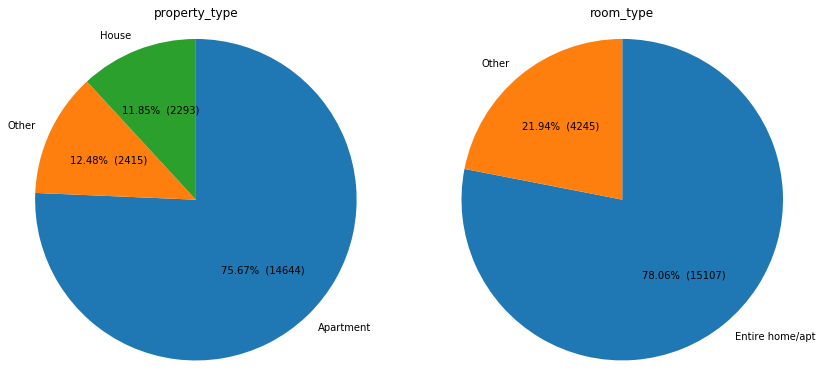

In [11]:
#Let's compare room type and property type.
#I'll add a constant column to the dataframe, to have a simpler dataframe after groupby.
df1['constant'] = 1
df_temp = df1.groupby(['room_type', 'property_type'])['constant'].count().to_frame().reset_index()
print(df_temp)

plt.figure(figsize = [14, 7])
plt.subplot(1, 2, 1)
my_piechart (df1, 'property_type')
plt.subplot(1, 2, 2)
my_piechart(df1, 'room_type')

* Actually, except for 1,248 listings, it concerns an apartment or home/house. I think the distinction between these two columns is hard to grasp (even before recoding). Airbnb should consider what the information they want out of these two columns.

* I will leave both columns in.

<a id='explorenumeric'></a>
### 2.1.6 Explore numeric columns

In [12]:
#Explore numeric columns.
num_cols = df1.select_dtypes(include=['int', 'float']).copy().columns
#print(df1[num_cols].info())
#print(df1[num_cols].describe())

<a id='findingsexplorenumeric'></a>
### 2.1.7 Findings exploring numeric columns

Using .describe() on numeric fields, my findings are: 

* For **host_listings_count**, we have a better version, namely **calculated_host_listings_count**. 
* I think the other **calculated_host_listings** columns are not relevant for my business questions. if they would be relevant, then for the third question (predicting price). But all these are characteristics of the host, not of the listing. (I will make an exception for **calculated_host_listings_count**, that might indicate the professionalism of the host.)
* I cannot interpret the **availability** and all the **minimum/maximum_nights** columns. I will drop them.
* The **number_of_reviews**, **number_of_reviews_ltm**, **reviews_per_month** are very much alike. **number_of_reviews** stores the total number of reviews and will depend on the time of the listing is available; **number_of_reviews_ltm** is one moment in time only. I will remove both and keep **reviews_per_month**, which represents the average number of reviews per month (at least, I think).
* Some columns stand out for their number of missing values. I will replace them by the mean.
* The scale of **review_scores_rating** runs to 100, while the other rating columns run to 10. I think **review_scores_rating** is the overall satisfaction, the other are rating on specific aspects (one could argue whether **value for money** is a specific aspect, or a proxy to measure overall satisfaction too).
* The names of the rating columns, e.g.**review_scores_rating**, **review_scores_accuracy**, are rather long.
* I think the column name *id* is better renamed to **listing_id**, to express that they are id's of listings.

Note: For the rating columns (e.g., **review_scores_rating**, **review_scores_accuracy**), I will *not* replace missing values because these columns show little variance and I do not want to reduce that variance further.

<a id='wranglingnumericcolumns'></a>
### 2.1.8 Wrangling numeric columns

I will:

* Drop columns.
* Fill in missing values for selected columns.
* Rename the id column and rating columns.

In [13]:
#Drop columns.
num_cols_to_drop = ['availability_30', 'availability_30', 'availability_60','availability_90','availability_365',
                    'minimum_minimum_nights', 'maximum_minimum_nights',
                    'minimum_maximum_nights', 'maximum_maximum_nights','minimum_nights_avg_ntm',
                    'maximum_nights_avg_ntm', 'host_listings_count', 'host_total_listings_count',
                    'calculated_host_listings_count_entire_homes',
                    'calculated_host_listings_count_private_rooms',
                    'calculated_host_listings_count_shared_rooms',
                    'number_of_reviews',
                    'number_of_reviews_ltm']

df1.drop(num_cols_to_drop, axis = 1, inplace = True)
#print(df1.info())

In [14]:
#Fill in missing values for a number of columns with the mean of that column.
cols = ['host_acceptance_rate', 'security_deposit', 'cleaning_fee',
        'bathrooms', 'bedrooms', 'beds', 'years_being_host']
fill_mean = lambda col: col.fillna(col.mean()) # Mean function
df1 [cols]= df1[cols].apply(fill_mean, axis=0)

In [15]:
#Rename columns.
df1.rename(columns={'id': 'listing_id', 
                    'review_scores_rating':        'rating_overall',
                    'review_scores_accuracy':      'rating_accuracy',
                    'review_scores_cleanliness':   'rating_cleanliness',
                    'review_scores_checkin':       'rating_checking_in',
                    'review_scores_communication': 'rating_communication',
                    'review_scores_location':      'rating_location',
                    'review_scores_value':         'rating_value_for_money'}, 
          inplace = True)

#It might be useful to define a list for the rating columns that have the same scale. 
ratings = ['rating_accuracy', 'rating_cleanliness','rating_checking_in', 
           'rating_communication', 'rating_location', 'rating_value_for_money']
#print(df1[ratings].describe())

In [16]:
#Examine the dataframe after the above transformations for categorical and numeric columns.
print(df1.shape)
#print(df1.describe)
#print(df1.info())

(19352, 35)


<a id='unitofanalysis'></a>
### 2.1.9 Note on the unit of analysis

It is important to observe that listing id's are unique, but host_id's are not. There are 19,352 unique listings, but only 16,856 unique host id's. There is even one host who apparently has 78 listings for rent (looking at the data for this host, it appears to be a regular host).

That means that a value count of the **host_is_superhost** column does not give the true number of regular and superhosts because if a certain host has ***n*** listings, he or she will contribute with a count of ***n*** in the table, not with a count of 1. Or, if we compute the mean rating for the regular- and superhosts, it will computed across listing_id's, not host_id's. Again, a host_id with ***n*** listing_id's will count ***n*** times when computing the mean.

The following cells illustrate this note. For example, from the value count table you cannot conclude that there are 16,506 regular hosts in this data because the regular host with 78 listings counts 78 times in the table, not 1 time. 

I suspected that **calculated_host_listings_count** stores the number of listing a host has, and I can validate that that is correct because all the statistics are the same.

In [17]:
#Value counts for host_is_superhost; handle results with care...
print(df1['host_is_superhost'].value_counts(),"\n")

#First 5 listings of the host who has the most listings.
most_listings= df1.groupby('host_id')['host_id'].count().sort_values(ascending=False).index[0]
print(df1[df1['host_id'] == most_listings][['listing_id', 'host_id', 'host_is_superhost']] [0:5], "\n")

#Validate that calculated_host_listings_count stores the number of listings that a host has.
print(df1.host_id.value_counts().describe(),"\n")
print(df1.groupby('host_id')['calculated_host_listings_count'].mean().describe())

No     16506
Yes     2835
Name: host_is_superhost, dtype: int64 

      listing_id  host_id host_is_superhost
2512     5045275  1464510                No
3657     7394002  1464510                No
4249     8601253  1464510                No
4615     9357030  1464510                No
4705     9536529  1464510                No 

count    16856.000000
mean         1.148078
std          1.085171
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         78.000000
Name: host_id, dtype: float64 

count    16856.000000
mean         1.148078
std          1.085171
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         78.000000
Name: calculated_host_listings_count, dtype: float64


<a id='listingsummaries'></a>
### 2.2 Explore listing summaries

The second dataset stores information as well about listings. I will import this data and then merge the datasets to see if this second dataset has columns which are identical to what we have in the details data set.

<a id='importdatadf2'></a>
### 2.2.1 Import, explore, and wrangle the data

Import the data and apply same type of transformations as for the first data set (drop columns with more than 50% missings, remove irrelevant columns, ).


In [18]:
df2 =  pd.read_csv('AMSTERDAM_listings.csv')
print (df2.shape)

# Drop name columns.
df2.drop(['name', 'host_name'], axis=1, inplace=True)

# Drop columns with more than 80% missing values.
most_missing_cols = set(df2.columns[df2.isnull().mean() > 0.50])

#I will drop the same columns as I have dropped for the first dataframe.
cols_to_drop =['number_of_reviews','last_review', 'availability_365']
df2.drop(cols_to_drop, axis=1, inplace=True)

df2.drop(most_missing_cols, axis=1, inplace=True)
print(df2.shape)
#print(df2.info())

(19352, 16)
(19352, 10)


<a id='findings_listings'></a>
### 2.2.2 Findings exploring listings data set

* This data set stores the same columns as the listing details data set.

* The data set is cleaner than the listing details data set. For example, price is without dollar sign in this second data set. That said, because I already cleaned the first data set (so I have price without a dollar sign there as well), the question is what this second data set adds. I suspect nothing, but I want to validate that.

* I will merge the data sets and check for duplicate columns.


<a id='mergedf1df2'></a>
### 2.3 Merge the datasets

In [19]:
#We have several columns with the same names. The merge will have a problem with that.
#Therefore, I will first rename the columns in the second dataset.
df2.rename(columns=lambda x: x + '_2', inplace=True)
df2.rename(columns={'id_2': 'listing_id'}, inplace = True)

#Merge the datasets; both data sets have the same number of records (19,352). 
#If these are the same records, an inner join should give that same number of records.
df = pd.merge(left=df1, right=df2, how='inner', left_on='listing_id', right_on='listing_id')
print(df.shape)
#print(df.info())

(19352, 44)


<a id='checkequality'></a>
### 2.3.1 Check on the equality of some columns, and drop if they are equal

* I will check the equality of a number of columns, and drop the column from the second dataframe if a column is duplicated

In [20]:
cols_df1 = ['host_id', 'neighbourhood_cleansed', 'latitude', 'longitude', 'room_type', 'price', 
            'minimum_nights', 'reviews_per_month', 'calculated_host_listings_count']

cols_df2 = ['host_id_2', 'neighbourhood_2', 'latitude_2', 'longitude_2', 'room_type_2', 'price_2', 
            'minimum_nights_2', 'reviews_per_month_2', 'calculated_host_listings_count_2']

for i, j in zip (cols_df1, cols_df2):
    n_equal = (df[i] == df[j]).sum()
    if n_equal == df.shape[0]:
        df.drop(j, axis = 1, inplace = True)
#df.info()        

In [21]:
#All columns from the second data frame are duplicate, except for review_per_month. 
#Not sure what happens here. I will check them by looking at the first records, and running statistics.
print(df[['reviews_per_month', 'reviews_per_month_2']].head(3))
print(df[['reviews_per_month', 'reviews_per_month_2']].describe())

   reviews_per_month  reviews_per_month_2
0               2.04                 2.04
1               0.44                 0.44
2               2.72                 2.72
       reviews_per_month  reviews_per_month_2
count       16960.000000         16960.000000
mean            0.744867             0.744867
std             1.216225             1.216225
min             0.010000             0.010000
25%             0.170000             0.170000
50%             0.380000             0.380000
75%             0.770000             0.770000
max            50.000000            50.000000


In [22]:
#For all practical purposes, these columns are the same. I will delete the column from the second data frame.
df.drop('reviews_per_month_2', axis = 1, inplace = True)

#In the second data set, I have the room type, but this is the same as the original room type in
#the first data set, and which I decided to recode. In short, I will remove room_type_2 as well.
df.drop('room_type_2', axis = 1, inplace = True)
print(df.shape)
#print(df.info())

(19352, 35)


<a id='checkmissings'></a>
### 2.3.2 Check on missing values

* I will check how many rows remain when I drop rows with a certain number of missing values (or less).

In [23]:
for i in range(df.isnull().sum(axis=1).max()+1):
    print ("Number of records remaining when at most ", i, " missing values are allowed: ", df[df.isnull().sum(axis=1) <= i].shape[0])                            

Number of records remaining when at most  0  missing values are allowed:  16705
Number of records remaining when at most  1  missing values are allowed:  16709
Number of records remaining when at most  2  missing values are allowed:  16719
Number of records remaining when at most  3  missing values are allowed:  16727
Number of records remaining when at most  4  missing values are allowed:  16731
Number of records remaining when at most  5  missing values are allowed:  16733
Number of records remaining when at most  6  missing values are allowed:  16738
Number of records remaining when at most  7  missing values are allowed:  16960
Number of records remaining when at most  8  missing values are allowed:  19350
Number of records remaining when at most  9  missing values are allowed:  19351
Number of records remaining when at most  10  missing values are allowed:  19352


##### Note on missing values

* We have 35 columns; the maximum number of missings for a record is 10. I think it is acceptable to retain all records. 

<a id='findings_merge'></a>
### 2.3.3 Findings merging data sets

The listings data set does not add new information, compared to the cleaned listing details data set.

<a id='premodeling'></a>
### 3. Pre-modeling

Before the modeling stage, I think it is a good idea to get a feeling for the distributions and relationships in the data. 

After running charts to get the first insights, I will answer the business questions in the next section.

<a id='regular_and_superhosts'></a>
### 3.1  Number of regular- and superhosts 

As noted before, a certain regular- or superhost  might not be unique, because s/he might have multiple listings. 

Therefore, we cannot count the number of regular/superhosts directly, but first have to create a dataset where host_id is unique. 

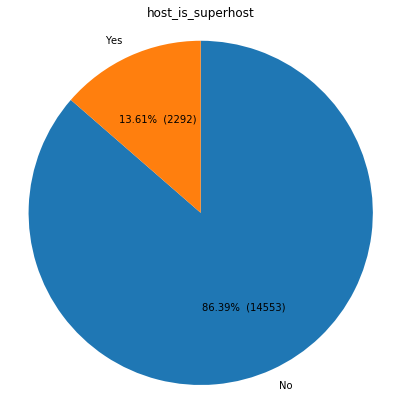

In [24]:
#Recall I have added a constant column to the data frame, to have a simpler data set after a groupby.
df_temp = df.groupby(['host_id', 'host_is_superhost'])['constant'].count().to_frame().reset_index()
plt.figure(figsize = [7, 7])
my_piechart (df_temp, 'host_is_superhost')

* About 14% of the hosts is superhost.

<a id='neighbourhood'></a>
### 3.2 The 10 neighbourhoods with the most listings

* I will select the top 10 neighborhoods, top 10 in terms of the neighborhoods with the most listings.

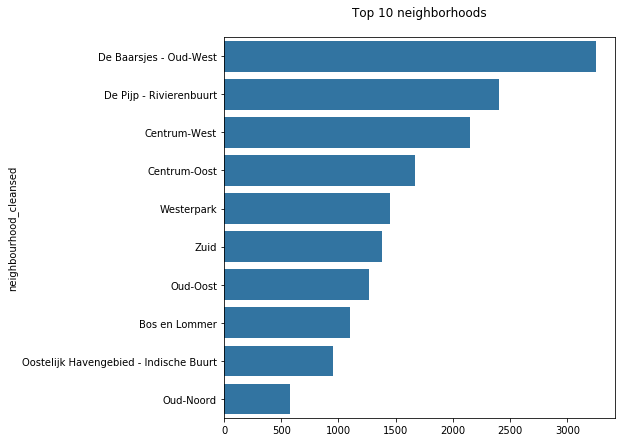

In [25]:
plt.figure(figsize = [7, 7])
base_color = sb.color_palette()[0]
neighbourhood_top10  = df['neighbourhood_cleansed'].value_counts().index[0:10]
df_temp = df[df['neighbourhood_cleansed'].isin(neighbourhood_top10)]['neighbourhood_cleansed'].to_frame().reset_index()
sb.countplot(data = df_temp, y = 'neighbourhood_cleansed', color = base_color, order = neighbourhood_top10)
plt.title("Top 10 neighborhoods\n")
plt.xlabel("")
plt.show();

#### Findings:

* Most listings are offered in De Baarsjes, which is a neighbourhood close to the center. 

* Center-West and Center-East also have a substiantial number of listings, which might be surprising because I think there are fewer apartments and houses in those areas.

<a id='price'></a>
### 3.3  Price

In [26]:
df['price'].describe()

count    19352.000000
mean       165.933340
std        236.859423
min          5.000000
25%         99.000000
50%        130.000000
75%        188.000000
max       9000.000000
Name: price, dtype: float64

#### Findings

A describe on price shows that the third quartile is 188, but the max is 9,0000. This latter value will distort the histogram.

Let's look at the last 5 percentiles of price, to determine the range for the histogram.

To avoid an error mesage about equal edges, I'll drop the requirement to have the same number of records in each bin (duplicates ='drop').

In [27]:
print (df.groupby(pd.qcut(df.price, 100, duplicates='drop'))['price'].count()[-5:]) 

price
(349.0, 360.0]     191
(360.0, 400.0]     217
(400.0, 490.0]     167
(490.0, 600.0]     212
(600.0, 9000.0]    173
Name: price, dtype: int64


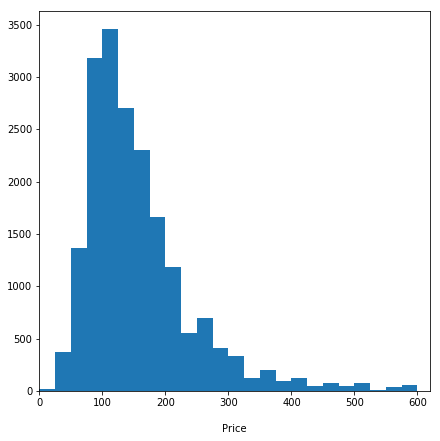

In [28]:
#Let's have an upper value of 600; this will cover 99.1% (((19,352 - 173) / 19,352) * 100) of the data.
plt.figure(figsize = [7, 7])
bins = np.arange(0, 620, 25)
plt.hist(df['price'], bins = bins)
plt.xlim((0,620))
plt.xlabel('\nPrice')
plt.show();

#### Findings

* The distribution is skewed to the right (it has a right tail). In the modeling stage, answering the third question about the price for a typical property, when we predict price, we could try a log transformation and see if that improves the prediction.

<a id='price_neighbourhood'></a>
### 3.4  Price by neighbourhood

* Mean price of the listings, for the 10 most expensive neighborhoods. 

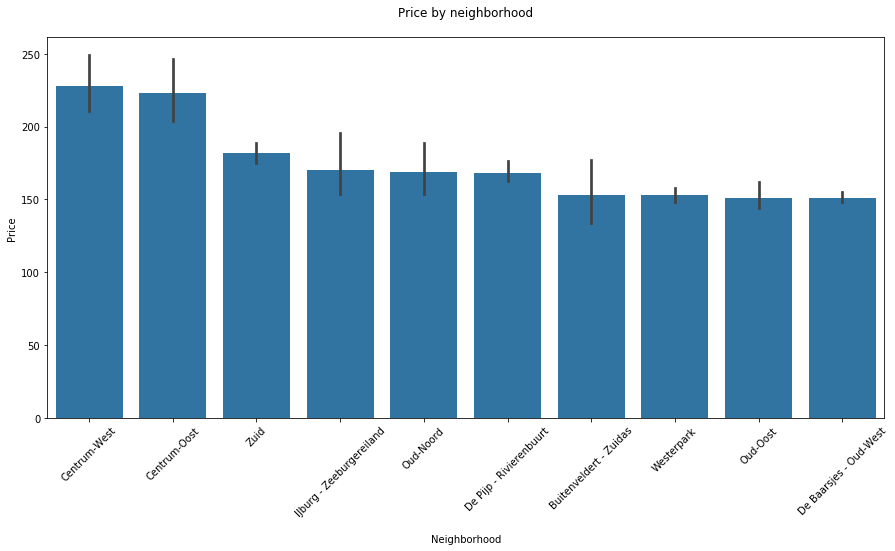

In [29]:
top10_mean_price = df.groupby('neighbourhood_cleansed').mean()['price'].sort_values(ascending=False).index[0:10]
df_temp = df[df['neighbourhood_cleansed'].isin(top10_mean_price)]
plt.figure(figsize = [15, 7])
sb.barplot(data = df_temp, x = 'neighbourhood_cleansed', y = 'price',
           color = base_color, order = top10_mean_price)
plt.xlabel('\nNeighborhood')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.title("Price by neighborhood\n")
plt.show();

#### Findings

* The listings in the center of Amsterdam are most expensive, which could be expexted. They are about 225 a night. 

* There is no significant difference between Center West and Center (the confidence intervals overlap).  

* Followed at quite some distance comes Amsterdam-Zuid, at approximately 175 a night. Amsterdam-Zuid is known for its more wealthy people living there, so this could as well be expected. 

* Quite surprising is that Oud-Noord is in the top 10, becsause this neighborhood is across the river.

* The  price of listings in  Westerpark is also surprising, because this is very close to the center and a very popular neighbourhood for Amsterdam inhabitants. 

* Neighbourhood seems to be important for price, so we need to control for neighbourhood if we want to assess relationships between other columns (such as being a regular- or a superhost and price. 

<a id='answeringbusinessquestions'></a>
### 4. Modeling - Answering the business questions

Questions:

* Are superhosts really super?
* What are the drivers of customer satisfaction?
* What is a fair price of a typical listing?

<a id='businessquestion1'></a>
### 4.1 Are superhosts really super?

I will look at the following indicators:
* mean price for regular- and superhosts, taking into account neighborhood
* mean score on the rating columns, for regular- and superhosts 
* is the listing instant bookable?


For the analysis, host_id's should be unique, see the discussion in section 2.1.9.

<a id='businessquestion1_price'></a>
### 4.1.1 Difference with respect to price

* I will only look at 10 neighborhoods with most listings.
* Recall that neighbourhood_top10 indicates the 10 neighbourhoods with most listings.

In [30]:
df_top10 = df[df['neighbourhood_cleansed'].isin(neighbourhood_top10)]
df_temp = df_top10.groupby(['host_id', 'host_is_superhost', 'neighbourhood_cleansed'])['price'].mean().to_frame().reset_index()

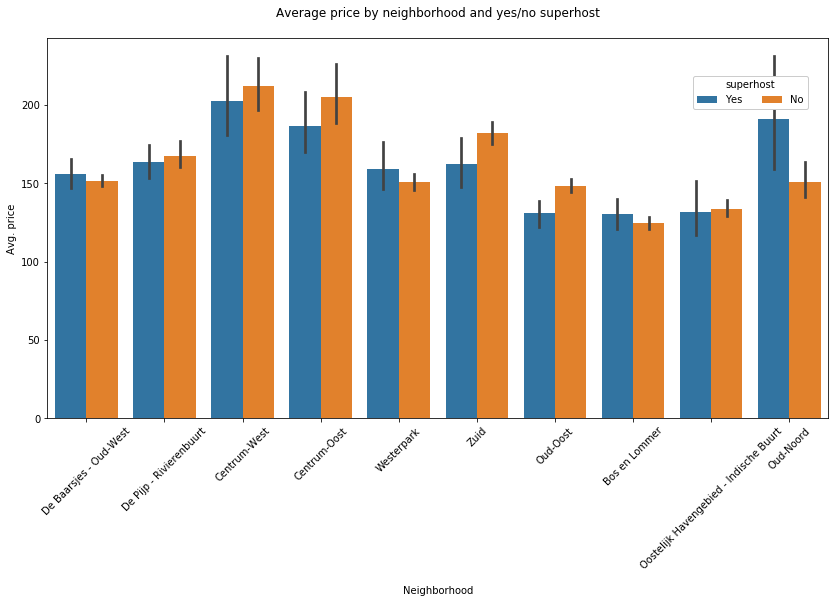

In [31]:
plt.figure(figsize = [14, 7])
ax = sb.barplot(data = df_temp, x = 'neighbourhood_cleansed', y = 'price',hue = 'host_is_superhost',
               order = neighbourhood_top10)
ax.legend(loc = 8, bbox_to_anchor = (0.9, 0.80), ncol = 3, framealpha = 1, title = 'superhost')
plt.title('Average price by neighborhood and yes/no superhost\n')
plt.xlabel('\nNeighborhood')
plt.ylabel('Avg. price')
plt.xticks(rotation=45)
plt.show();

<a id='businessquestion1_overall_rating'></a>
### 4.1.2 Difference with respect to overall rating

host_is_superhost
No     95.128882
Yes    97.531080
Name: rating_overall, dtype: float64


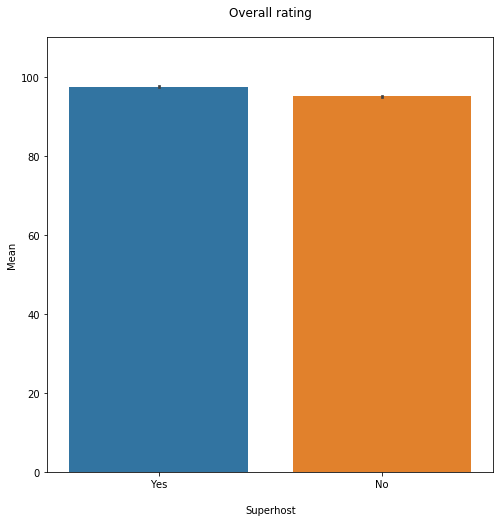

In [32]:
df_temp = df.groupby(['host_id', 'host_is_superhost'])['rating_overall'].mean().reset_index()
print(df_temp.groupby('host_is_superhost')['rating_overall'].mean())
plt.figure(figsize = [8, 8])
ax = sb.barplot(data = df_temp, x = 'host_is_superhost', y = 'rating_overall')
ax.legend(loc = 8, bbox_to_anchor = (1.0, 0.9), ncol = 3, framealpha = 1, title = 'Superhost')
plt.ylabel('Mean')
plt.xlabel('\nSuperhost')
plt.title('Overall rating\n')
plt.ylim (0, 110)
plt.show();

<a id='businessquestion1_ratings'></a>
### 4.1.3 Difference with respect to aspect ratings

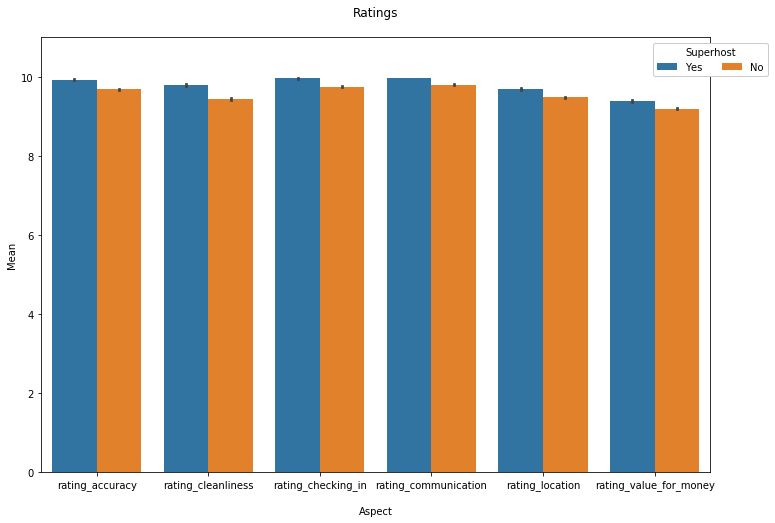

In [33]:
#Again, make hosting id's unique.
#Recall that ratings is a list referring to the rating columns on a 10-point scale.
df_temp = df.groupby(['host_id','host_is_superhost'])[ratings].mean().reset_index()

#To create the chart, I will restructure the data, so that what I now have as columns will be rows,
#and a column indicating which aspect it concerns
df_melted = pd.melt(df_temp, id_vars=['host_id', 'host_is_superhost'], value_vars=ratings)
plt.figure(figsize = [12, 8])
ax = sb.barplot(data = df_melted, x = 'variable', y = 'value', hue = 'host_is_superhost')
ax.legend(loc = 8, bbox_to_anchor = (1.0, 0.9), ncol = 3, framealpha = 1, title = 'Superhost')
plt.ylabel('Mean')
plt.xlabel('\nAspect')
plt.title('Ratings\n')
plt.ylim (0, 11)
plt.show();

<a id='businessquestion1_instant_bookable'></a>
### 4.1.4 Difference with respect to instant bookable

Let's see if superhosts are more flexible than regular hosts.

In [34]:
cat1_order = df['host_is_superhost'].value_counts().index
cat2_order = df['instant_bookable'].value_counts().index

artists = [] # for storing references to plot elements
baselines = np.zeros(len(cat1_order))
cat1_counts = df['host_is_superhost'].value_counts()

plt.figure(figsize = [7, 7])
# for each second-variable category:
for i in range(len(cat2_order)):
    # isolate the counts of the first category,
    cat2 = cat2_order[i]
    inner_counts = df[df['instant_bookable'] == cat2]['host_is_superhost'].value_counts()
    inner_props = inner_counts / cat1_counts
    # then plot those counts on top of the accumulated baseline
    bars = plt.bar(x = np.arange(len(cat1_order)),
                   height = inner_props[cat1_order],
                   bottom = baselines)
    artists.append(bars)
    baselines += inner_props[cat1_order]

plt.xticks(np.arange(len(cat1_order)), cat1_order)
plt.legend(reversed(artists), reversed(cat2_order), framealpha = 1,
           bbox_to_anchor = (1, 0.5), loc = 6)
plt.xlabel('\nIs a superhost?')
plt.ylabel('Proportion')
plt.title('Relationship between instant bookable and being superhost\n')

plt.show();

Question to the reader: do you think that this figure is correct? :-) 

<a id='conclusion_question_1'></a>
### 4.1.5 Conclusion

* There is a small difference in price between listings of regular and superhosts, but whether this is a positive or negative difference depends on the neighbourhood. So, you _cannot_ conclude that the (mean) price for superhost listings is higher than the (mean) price for regular host listings.

* On average, superhosts score 2.4 higher than regular hosts (97.5 vs. 95) in overall rating.

* Superhosts score higher on all aspects than regular hosts.

* The difference on all ratings (be it overall or  aspects) is significant, which can be explained from the large amount of records (and the small variance of the rating columns because this also determines the standard error).

* Listings by superhosts are more flexible, in terms of instant bookable. But needs further analysis to analyze at the right unit of analysis (hosts, not listings).

In conclusion, superhosts do better and seem to be more flexible, but they are not more expensive, so I would recommend a superhost if possible. So, yes, indeed, superhosts are indeed super!

<a id='businessquestion2'></a>
### 4.2 What are the drivers of customer satisfaction?

In customer satisfaction research, it is common use to have a variable that measures the overall satisfaction on one side, and satisfaction scores on a number of aspects on the other side. The question then is which of the aspects drive the overall satisfaction.

The data set here reflects such a situation, where we have overall rating on one side, and satisfaction scores on accuracy, cleanliness, checking in, communication, location, value for money on the other side. 

One could argue whether the last aspect, "value for money" also taps "general satisfaction" or whether it is an aspect rating as well. If it also measures general satisfaction, the correlation with overall satisfaction will be higher than 0.8, and if that is the case, I will leave it out (not include it as a driver).

Because all the columns are quantitative (well, we may assume that scores on a 1 - 10 point scale are of a quantitative nature, although one might argue that these are ordinal scores at most), we can use regression to say how much variance we can explain in the general satisfaction, using the aspects as independents.

I will first examine the correlations to see if we can expect problems because the predictors correlate to a high degree (multicollinearity, which will bias significance).

<a id='correlations'></a>
#### 4.2.1 Correlations between the rating columns

In [35]:
all_ratings = ['rating_overall'] + ratings
df_temp = df[all_ratings]
df_temp.describe()

rating_overall  rating_accuracy  rating_cleanliness  \
count    16738.000000     16727.000000        16728.000000   
mean        95.189987         9.700126            9.475849   
std          6.688861         0.699748            0.878057   
min         20.000000         2.000000            2.000000   
25%         93.000000        10.000000            9.000000   
50%         97.000000        10.000000           10.000000   
75%        100.000000        10.000000           10.000000   
max        100.000000        10.000000           10.000000   

       rating_checking_in  rating_communication  rating_location  \
count        16719.000000          16727.000000     16721.000000   
mean             9.762306              9.805584         9.513546   
std              0.629146              0.604388         0.695989   
min              2.000000              2.000000         2.000000   
25%             10.000000             10.000000         9.000000   
50%             10.000000             10.000000        10.000000   
75%             10.000000             10.000000        10.000000   
max             10.000000             10.000000        10.000000   

       rating_value_for_money  
count            16721.000000  
mean                 9.201244  
std                  0.809476  
min                  2.000000  
25%                  9.000000  
50%                  9.000000  
75%                 10.000000  
max                 10.000000

In [36]:
#I will drop all records with a missing value. 
#(As noticed, I do not want to impute missing values, because it will (even more) reduce the variance.)
df_temp.dropna(axis = 0, inplace = True)
df_temp.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(16715, 7)

In [37]:
plt.figure(figsize = [10, 10])
sb.heatmap(df_temp.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0)
plt.show();

#### Findings

* The correlations are moderate.

* The overall rating correlates most to the rating of accuracy. It remains to be seen whether this is the strongest predictor in a multivariate analysis.

* The correlation between overall rating and value for money is 0.68, which is, I think, not high enough to conclude that these are two indicators of the same concept (a correlation of 0.68 means they have 0.68**2 of variance in common, which is less than 50%).

<a id='unstandardized'></a>
#### 4.2.2 Identify the drivers of overall rating (unstandardized solution)

I used the example from: https://datatofish.com/multiple-linear-regression-python/. There, two methods are listed:
* linear model from sklearn 
* statsmodel

I liked statsmodel best because that gives the most complete output.

In [38]:
X = df_temp[ratings]
y = df_temp['rating_overall']

#Using statsmodels.
X = sm.add_constant(X) # adding a constant
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         rating_overall   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     7071.
Date:                Fri, 07 Aug 2020   Prob (F-statistic):               0.00
Time:                        07:05:12   Log-Likelihood:                -44873.
No. Observations:               16715   AIC:                         8.976e+04
Df Residuals:                   16708   BIC:                         8.981e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

#### Findings

The R-square is 0.72, which is a fair amount of explained variance. That said, apparently people also value aspects that are not included in this data set. So, the question is what these aspects are, and if there are aspects which actually might be more important than the one in this data set.

All coefficients are significant, but given the size of the data set (16,000+), that does not come as a surprise.

Because the aspect ratings are in the same unit, we can compare the coefficients. 

The coefficient for accuracy is the largest. If a listing is valued 1 point higher in accuracy, that yields an increase in the overall_rating of 2.5 points. 

Besides accuracy, cleanliness, value for money, and communication are important.

Location does not appear that important.

As a note, the overall_rating is on 10 - 100 scale, but more 95% of the listings have an overall rating between 83 and 100. So, a 2.5 increase is substantial, I would say.

<a id='standardized'></a>
#### 4.2.3 Identify the drivers of overall rating (standardized solution)

The output does not report on the standardized coefficients (the "betas" as they are commonly called). In this case, that is not a big issue, because the predictors have the same unit of measurement (10 point scale).

Still, I want to have the betas. The beta's are just the regression coefficients computed on the standardardized variables, so I can standardize the variables and then rerun the regression. 

In this case, I do not need the constant because it will be 0. But besides, including the constant will
yield an error because the "standardized constant" will be missing (because the standard deviation of the
constant is 0), and therefore the X matrix will not be positive definite.  

In [39]:
X.drop('const', axis = 1, inplace = True)
model = sm.OLS(zscore(y), zscore(X)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     7071.
Date:                Fri, 07 Aug 2020   Prob (F-statistic):               0.00
Time:                        07:05:12   Log-Likelihood:                -13155.
No. Observations:               16715   AIC:                         2.632e+04
Df Residuals:                   16709   BIC:                         2.637e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2532      0.006     44.125      0.0

* Accuracy, cleanliness, value_for_money are again the most important, but cleanliness now has taken the number 1 role. When cleanliness increases by 1 standard deviation, overall rating increases by 0.28 standard deviation. 

<a id='conclusion_question_2'></a>
### 4.2.4 Conclusion

* Accuracy, cleanliness, value_for_money are again the most important for the customer's overall rating.

* "Accuracy" and "value for money" are maybe hard to measure, so if I would be a Airbnb host, I would especially work on the cleanliness. That will improve the customer experience significantly.

<a id='businessquestion3'></a>
### 4.3 What is a fair price to ask for a typical object in Amsterdam?

<a id='derive_distance'></a>
### 4.3.1 Derive distance to the city center

In [40]:
#I will compute a new column, the distance to the city center.
#This column might be a more accurate indicator of the location than the neighbourhood
#(In fact, what we would really would like to know is the distance to the city center in time...)

#The GPS coordinates of Dam Square (the center of Amsterdam) are:
#- Latitude 52.3730
#- Longitude: 4.8930


df['distance_to_cc'] = ((df['latitude'] - 52.3730) ** 2 + (df['longitude'] - 4.8930) ** 2) ** 0.5

print (df[['latitude', 'longitude', 'distance_to_cc']].head(3))

   latitude  longitude  distance_to_cc
0  52.36575    4.94142        0.048960
1  52.37802    4.89270        0.005029
2  52.36509    4.89354        0.007928


In [41]:
#I want to validate the computation of the distance.
cat_order = df.groupby('neighbourhood_cleansed').mean()['distance_to_cc'].sort_values(ascending=True).index
plt.figure(figsize = [15, 7])
base_color = sb.color_palette()[0]
sb.barplot(data = df, x = 'distance_to_cc', y = 'neighbourhood_cleansed',  order = cat_order, color = base_color, ci = None)
plt.xlabel('\nDistance to city center')
plt.ylabel('Neighbourhood')
plt.xticks(rotation=45)
plt.title("Distance to center by neighbourhood\n")
plt.show();

This figure validates that distance is computed correctly; the two center regions have the smallest distance. Gaasperdam - Driemond (a separate municipality) is at the largest distance.

<a id='nomissingsforratings'></a>
### 4.3.2 Select records with no missings for rating columns

I do not want to impute missing values for the rating columns because it would reduce the variance of these columns further, and therefore the predictive power of them.

In [42]:
df = df[df[all_ratings].isnull().sum(axis=1)==0]
print(df.shape)
#print(df.info())

(16715, 36)


<a id='whatistypical1'></a>
### 4.3.3 Select "typical" listings by business rules

Notice that the business questions talks about "typical" listings. I want to know the price of a "typical" listing. "Typical" listings are hard to define, but in any case, a listing with a price of 1500, or a listing with 26 bedrooms, and such, would be a-typical. Such a-typical listings are outside the domain of the business question. Therefore, I need to exclude a-typical records from the model building stage.

I'll use two methods to select records to arrive at "typical" listings: business rules (like price less than a certain amount), and a data-driven method.

In [43]:
#I'll check the maximum value a number of characteristincs, how many people it can accomodate, number of batrooms, and such.
cols = ['accommodates','bathrooms', 'bedrooms', 'beds', 'guests_included', 'price']
df[cols].describe()[7:]

accommodates  bathrooms  bedrooms  beds  guests_included   price
max          17.0        8.0      12.0  32.0             16.0  9000.0

In [44]:
#Let's say I select listings up to 600 dollars (previously, we noted that this covers 95% of the data).
(df[df['price'] <= 600][cols].describe())[7:]

accommodates  bathrooms  bedrooms  beds  guests_included  price
max          17.0        8.0      12.0  32.0             16.0  600.0

#### Findings

If we select listings up to 600 dollars, price is okay, but we still have 12 bedrooms, 32 beds, and such.

It appears that it is hard to get these values right, in such a way that the data represents "typical" listings. And this will be even harder if we would like to check for more columns.

Alternatively, or in conjunction with, we can try a data-driven method.

<a id='whatistypical2'></a>
### 4.3.4 Select "typical" listings by data driven methods

Idea: I will perform K-Means on the columns on which I want to check, using 1 cluster. I can then measure the distance of a record to the cluster center, and then I will remove the 10 percent of records with the largest distance.

In [45]:
#Standardize the columns.
X_stand = zscore (df[cols])
km = KMeans(n_clusters=1)

#To get the distance between a record and the cluster centroid, I used:
#https://datascience.stackexchange.com/questions/26206/calculate-distance-between-each-data-point-of-a-cluster-to-their-respective-clus
distances = km.fit_transform(X_stand)

In [46]:
#In order to add it as a column with values to the data frame, distances have the wrong format 
#because values will be like "[1.234]") instead of "1.234".
#So, I need to convert them to a correct format. I used:
#https://stackoverflow.com/questions/1614236/in-python-how-do-i-convert-all-of-the-items-in-a-list-to-floats
distances_ok = [float(i) for i in distances]
df['distances'] = distances_ok 
print (df['distances'].describe())

count    16715.000000
mean         1.862714
std          1.590739
min          0.755239
25%          1.254893
50%          1.372114
75%          1.974581
max         52.898516
Name: distances, dtype: float64


In [47]:
print (df.groupby(pd.qcut(df.distances, 100, duplicates='drop'))['distances'].count() [80:]) 

distances
(2.3808, 2.464]      167
(2.464, 2.5617]      170
(2.5617, 2.6729]     165
(2.6729, 2.8056]     167
(2.8056, 2.9588]     167
(2.9588, 3.0828]     167
(3.0828, 3.2747]     167
(3.2747, 3.4324]     167
(3.4324, 3.6222]     168
(3.6222, 3.8062]     167
(3.8062, 4.0749]     167
(4.0749, 4.4094]     167
(4.4094, 4.9219]     167
(4.9219, 5.433]      167
(5.433, 6.7212]      167
(6.7212, 52.8985]    168
Name: distances, dtype: int64


In [48]:
#I will use 3 as a threshold for the distance to the cluster center. This covers 90% of the listing.
#Also, the maximum values look okay.
df = df[df['distances'] <= 3]
print(df[['accommodates','bathrooms', 'bedrooms', 'beds', 'guests_included', 'price']].describe()[7:])

     accommodates  bathrooms  bedrooms  beds  guests_included  price
max           6.0        2.0       3.0   5.0              4.0  600.0


<a id='predict_price'></a>
### 4.3.5 Modeling: predict price

I'll use regression and random forest to predict price.

Because the distribution of price was skewed, I will apply a log transformation and predict the log-transformed price, again using regression and random forest. 

In [49]:
cols = ['listing_id', 'host_id', 'constant', 'distances']
df_modeling_data=df.copy()
df_modeling_data.drop(cols, axis = 1, inplace = True)
df_modeling_data.shape

(14927, 33)

In [50]:
cat_predictors = df_modeling_data.select_dtypes(include=['object']).copy().columns
label = 'price'
r2_1, mae_1, mse_1, rmse_1, reg_model_price =  clean_fit_models(df_modeling_data, label, cat_predictors, dummy_na = False)
r2_2, mae_2, mse_2, rmse_2, rf_model_price  =  clean_fit_models(df_modeling_data, label, cat_predictors, dummy_na = False, algorithm='random_forest')

df_modeling_data['price_log'] = np.log(df_modeling_data['price'])
df_modeling_data.drop('price', axis = 1, inplace = True)
label = 'price_log'
r2_3, mae_3, mse_3, rmse_3, reg_model_price_log =  clean_fit_models(df_modeling_data, label, cat_predictors, dummy_na = False)
r2_4, mae_4, mse_4, rmse_4, rf_model_price_log  =  clean_fit_models(df_modeling_data, label, cat_predictors, dummy_na = False, algorithm='random_forest')

<a id='evaluation_models'></a>
### 4.3.6 Evaluation

In this section I will simply evaluate the models by looking at fit statistics such as R-Square.

In [51]:
print("\nResults on test set, using regression:")
print("-------------------------------------")
print("R-square:", r2_1)
print("Mean Absolute Error:", mae_1)
print("Mean Squared Error:", mse_1)
print("Root Mean Squared error:", rmse_1)

print("\nResults on test set, using random forest:")
print("-------------------------------------")
print("   R-square:", r2_2)
print("   Mean Absolute Error:", mae_2)
print("   Mean Squared Error:", mse_2)
print("   Root Mean Squared error:", rmse_2)

print("\nResults on test set, using regression, label: log of price:")
print("-------------------------------------")
print("R-square:", r2_3)
print("Mean Absolute Error:", mae_3)
print("Mean Squared Error:", mse_3)
print("Root Mean Squared error:", rmse_3)

print("\nResults on test set, using random forest, label: log of price:")
print("-------------------------------------")
print("R-square:", r2_4)
print("Mean Absolute Error:", mae_4)
print("Mean Squared Error:", mse_4)
print("Root Mean Squared error:", rmse_4)


Results on test set, using regression:
-------------------------------------
R-square: 0.381023369695
Mean Absolute Error: 35.1792607492
Mean Squared Error: 2564.03248262
Root Mean Squared error: 50.6362763502

Results on test set, using random forest:
-------------------------------------
   R-square: 0.442194004535
   Mean Absolute Error: 34.064735432
   Mean Squared Error: 2310.64085678
   Root Mean Squared error: 48.0691258166

Results on test set, using regression, label: log of price:
-------------------------------------
R-square: 0.456412169523
Mean Absolute Error: 0.243069541054
Mean Squared Error: 0.103211272079
Root Mean Squared error: 0.32126511183

Results on test set, using random forest, label: log of price:
-------------------------------------
R-square: 0.502398729157
Mean Absolute Error: 0.236109250497
Mean Squared Error: 0.0944797827918
Root Mean Squared error: 0.307375637928


#### Conclusion

The regression model, using predictors such as neighborhood, number of bathrooms, is the host yes or no superhost, the ratings, can explain 38% of the variance in price. Or, on average, the error is 35.17 in predicting the price (mean absolute error). Or, in the same spirit but then weighing large errors more heavily, the error is 50.63 (the root mean squared error).

With the same target, the RandomForest models performs better: the explained variance is 44% and the values for the metrics that measure the error are smaller.

The explained variance can be further improved if I predict the log of price. RandomForest then explains 50% of the variance in price.


<a id='deploy'></a>
### 4.3.7 Deploy the model

Deployment can vary from just having a table with the predicted values to developing an app that scores the data in real time. 

Here, I will just have the predicted value, for a "typical" listing.

Note: Normally, you would input the same type of data as the data used for modeling, but then, of course, without the label. You would then apply the same data transformations, such as cleaning the data, deriving new columns, and creating the dummies. But I ran into problems with creating the dummies. I just want to score a single property and creating dummies will issue an error message. Basically, I need all the same data as the input data so that the same same dummies will be created for my new data. On StackOverflow there is a post about this, to apply a "template" for creating dummies, but in combination with my function that took too much time to implement. Long story short: I just created a record manually, with all the dataprep already applied, so that I could just apply the model. 

In [52]:
#Read the data for one typical listing
new = pd.read_csv('new_data.csv')
for col in new.columns:
    print (col, ": ", new[col][0])

host_acceptance_rate :  75.0
latitude :  52.35477
longitude :  4.89675
accommodates :  2
bathrooms :  1.0
bedrooms :  2.0
beds :  2.0
security_deposit :  150.0
cleaning_fee :  25.0
guests_included :  2
extra_people :  30.0
minimum_nights :  2
maximum_nights :  90
rating_overall :  95.0
rating_accuracy :  10.0
rating_cleanliness :  10.0
rating_checking_in :  9.0
rating_communication :  9.0
rating_location :  9.0
rating_value_for_money :  10.0
calculated_host_listings_count :  2
reviews_per_month :  0.13
years_being_host :  0.0
distance_to_cc :  0.0186117006208
host_is_superhost_dummy_Yes :  0
host_identity_verified_dummy_Yes :  0
neighbourhood_cleansed_dummy_Bijlmer-Oost :  0
neighbourhood_cleansed_dummy_Bos en Lommer :  0
neighbourhood_cleansed_dummy_Buitenveldert - Zuidas :  0
neighbourhood_cleansed_dummy_Centrum-Oost :  0
neighbourhood_cleansed_dummy_Centrum-West :  0
neighbourhood_cleansed_dummy_De Aker - Nieuw Sloten :  0
neighbourhood_cleansed_dummy_De Baarsjes - Oud-West :  0
nei

In [53]:
print(reg_model_price.predict (new))
print(np.exp(reg_model_price_log.predict (new)))
print(rf_model_price.predict(new))
print(np.exp(rf_model_price_log.predict(new)))

[ 142.3652147]
[ 131.35454177]
[ 331.85]
[ 182.29215052]


#### Findings

The RandomForest model for price seems to derail.A possible explanation is that the listing falls into a branch in the trees such as "number of reviews > 2 then the predicted price equals 326, and whether the number of reviews 3 or 43 does does matter much any more. So, this actually comes down to the Evaluation stage, if a model is trustworthy and transparent. 

To generate trust for the best model, RandomForest for the log of price, let's see what happens if the host has 5 years of experience instead of 0.

In [54]:
new['years_being_host'] = 5
print(np.exp(rf_model_price_log.predict(new)))

[ 186.31031083]


So, if a host has 5 years more experience, all other variables at the same values, the price increases by 4. This seems reasonable. In any case, it is not unreasonable. So, I have reasonable trust in this model.


This concludes the analysis of the Airbnb data :-)